In [1]:
import numpy as np
import pandas as pd
import mne

def find_stim_events_single_subject(
    raw: mne.io.Raw,
    threshold: float = 0.5,
    include_subject_col: bool = False,
    subject_id: str = None
) -> pd.DataFrame:
    """
    Extract stim events from a single subject's Raw EEG data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Preloaded EEG data (e.g., from mne.io.read_raw_egi).
    threshold : float, optional
        Threshold for binarizing analog stim channels (default: 0.5).
    include_subject_col : bool, optional
        If True, adds a 'subject' column (useful for aggregation).
    subject_id : str, optional
        Subject identifier (required if include_subject_col=True).
    
    Returns
    -------
    events_df : pd.DataFrame
        Columns: ['channel', 'time_sec', 'sample', 'sfreq']
        (+ 'subject' if requested)
    """
    # --- Find stim channels ---
    stim_candidates = []
    for ch_name, ch_type in zip(raw.ch_names, raw.get_channel_types()):
        if ch_type in ['stim', 'misc']:
            stim_candidates.append(ch_name)
        elif any(kw in ch_name.upper() for kw in ['STI', 'TRIG', 'TTL']):
            stim_candidates.append(ch_name)
        elif ch_name[0].isdigit() and len(ch_name) <= 3:
            stim_candidates.append(ch_name)
    stim_channels = sorted(set(stim_candidates))
    
    # --- Extract events ---
    events = []
    sfreq = raw.info['sfreq']
    for ch in stim_channels:
        if ch not in raw.ch_names:
            continue
        data = raw.get_data(picks=[ch])[0]
        digital = (data > threshold).astype(int)
        diff = np.diff(digital, prepend=0)
        onset_samples = np.where(diff == 1)[0]
        onset_times = onset_samples / sfreq
        for t, s in zip(onset_times, onset_samples):
            row = {
                'channel': ch,
                'time_sec': t,
                'sample': int(s),
                'sfreq': sfreq
            }
            events.append(row)
    
    df = pd.DataFrame(events) if events else pd.DataFrame(
        columns=['channel', 'time_sec', 'sample', 'sfreq']
    )
    
    if include_subject_col:
        if subject_id is None:
            raise ValueError("subject_id must be provided if include_subject_col=True")
        df['subject'] = subject_id
    
    return df.sort_values('time_sec').reset_index(drop=True)

In [2]:
import matplotlib.pyplot as plt

def plot_stim_events_single(
    events_df: pd.DataFrame,
    subject_id: str = None,
    figsize: tuple = (12, 4)
):
    """
    Plot stim events over time for a single subject.
    
    Parameters
    ----------
    events_df : pd.DataFrame
        Output from `find_stim_events_single_subject`.
        Must contain columns: 'channel', 'time_sec'.
        May optionally contain 'subject'.
    subject_id : str, optional
        If provided, filters events_df by this subject.
        If omitted, assumes all rows belong to one subject.
    figsize : tuple, optional
        Figure size.
    """
    if events_df.empty:
        print("⚠️ No events to plot.")
        return
    
    # Filter by subject if needed
    if subject_id is not None and 'subject' in events_df.columns:
        df = events_df[events_df['subject'] == subject_id].copy()
    else:
        df = events_df.copy()
    
    if df.empty:
        print(f"⚠️ No events found for subject {subject_id}")
        return
    
    plt.figure(figsize=figsize)
    for ch in df['channel'].unique():
        ch_events = df[df['channel'] == ch]
        plt.scatter(ch_events['time_sec'], [ch] * len(ch_events), label=ch, alpha=0.7)
    
    title = f"Stim Events for {subject_id}" if subject_id else "Stim Events"
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Opening raw data file /mnt/movement/users/jaizor/xtra/derivatives/eeg/concat/bima_off_sub-001_concat_eeg.fif...
    Range : 126209 ... 328727 =    252.418 ...   657.454 secs
Ready.
Reading 0 ... 202518  =      0.000 ...   405.036 secs...


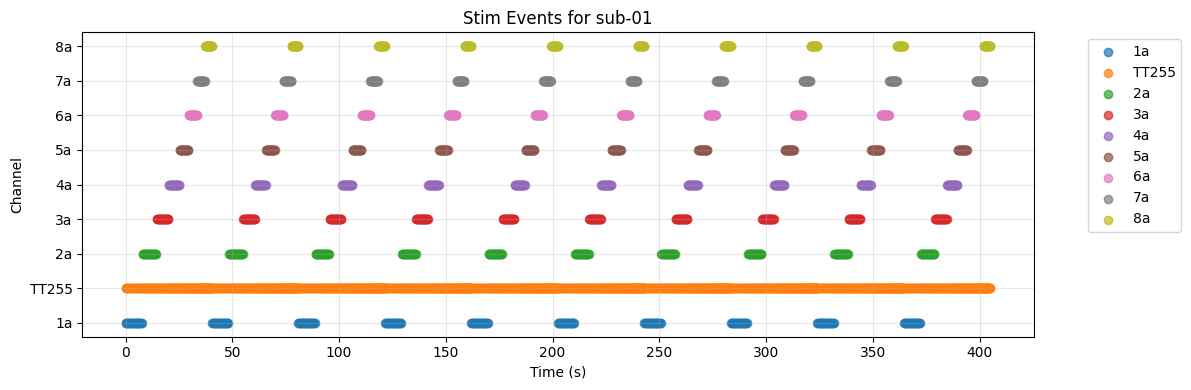

In [ ]:
# Load one subject
sub_path = "/cleaned_eeg.fif"  

#raw = mne.io.read_raw_egi(sub_path, preload=True)   # MFF
raw = mne.io.read_raw_fif(sub_path, preload=True)   # FIF

# Detect events
events = find_stim_events_single_subject(raw, include_subject_col=True, subject_id="sub-01")

# Plot
plot_stim_events_single(events, subject_id="sub-01")

In [6]:
events.head()

,channel,time_sec,sample,sfreq,subject
0,1a,0.000,0,500.0,sub-01
1,TT255,0.008,4,500.0,sub-01
2,1a,0.400,200,500.0,sub-01
3,TT255,0.408,204,500.0,sub-01
4,1a,0.802,401,500.0,sub-01
